In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential

In [2]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# mendownload dataset menggunakan API command dari kaggle
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
# mengekstrak file zip
import zipfile
zip_file = zipfile.ZipFile('/content/stock-time-series-20050101-to-20171231.zip')
zip_file.extractall('/content/')

In [5]:
df = pd.read_csv ('AABA_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA


In [6]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [7]:
category = pd.get_dummies(df.Name)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='Name')
new_df

,Date,Open,High,Low,Close,Volume,AABA
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,1
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,1
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,1
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,1
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,1
...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,1
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,1
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,1
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,1


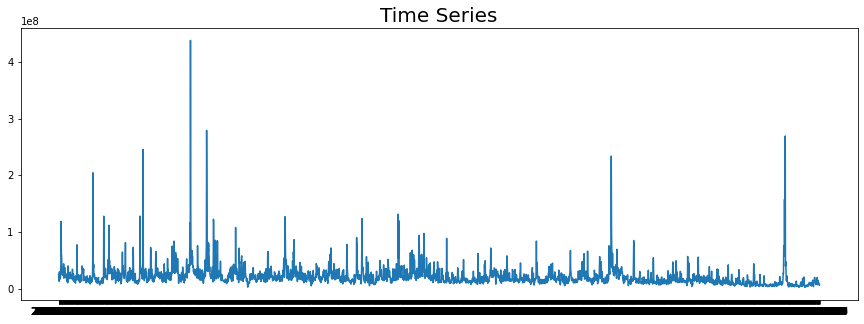

In [8]:
dates = df['Date'].values
volume = df['Volume'].values

plt.figure(figsize=(15, 5))
plt.plot(dates, volume)
plt.title('Time Series',
          fontsize=20);


In [9]:
#Normalisasi
from sklearn.preprocessing import MinMaxScaler
new_data = df.filter(['Volume'])

dataset = new_data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(dataset)

scaled

array([[0.05109797],
       [0.04266499],
       [0.02496157],
       ...,
       [0.01009887],
       [0.01287626],
       [0.01071301]])

In [10]:
X_train, X_test, y_train,y_test = train_test_split(dates, scaled, test_size=0.2)

In [11]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])


In [14]:
class myCallback(tf.keras.callbacks.Callback): 
 def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1) and (logs.get('val_mae')<0.10):
      print("\n Mae dibawah <10%!") 
      self.model.stop_training = True 
callbacks = myCallback()

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     24/Unknown - 7s 122ms/step - loss: 0.0013 - mae: 0.0301
 Mae dibawah <10%!
24/24 [==============================] - 9s 194ms/step - loss: 0.0013 - mae: 0.0301 - val_loss: 0.0010 - val_mae: 0.0293


<function matplotlib.pyplot.show(*args, **kw)>

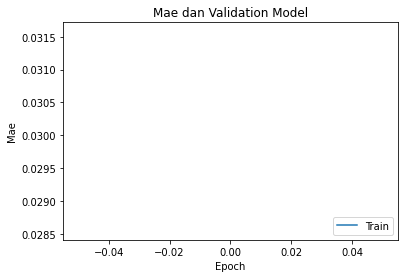

In [16]:
plt.plot(history.history['mae'])
plt.title('Mae dan Validation Model')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

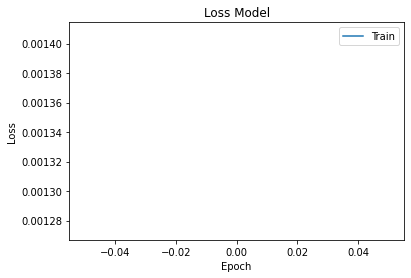

In [17]:
plt.plot(history.history['loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show